### PROYECTO: PREDICCIÓN DE LA TASA DE DESEMPLEO EN COLOMBIA: UN ESTUDIO COMPARATIVO DE MODELOS HÍBRIDOS Y AVANZADOS.

### MODELO ARIMA - ARNN

#### Elaborado por: Yairo Oviedo

In [1]:
# Cargue de libreria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
import keras_tuner as kt
pip install pmdarima keras keras-tuner scikit-learn



Note: you may need to restart the kernel to use updated packages.


In [130]:
# Fijar semillas
np.random.seed(0)
tf.random.set_seed(0)

# Leer el archivo CSV limpio
file_path = 'TD_BUSQUEDAS_GOOGLE.csv'
df_cleaned = pd.read_csv(file_path, sep=";", parse_dates=['Mes'], index_col='Mes')

# Rango de fechas a filtrar
fecha_inicio = '2014-01-01'
fecha_fin = '2024-04-30'

# Filtrar el DataFrame para el rango de fechas
df_cleaned = df_cleaned.loc[fecha_inicio:fecha_fin]

# Convertir columnas de tipo object a float si es necesario
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = df_cleaned[col].str.replace(',', '.').astype(float)

# Verificar y eliminar cualquier valor NaN en los datos
df_cleaned = df_cleaned.dropna()

# Extraer la serie temporal de la tasa de desempleo
ts_unemployment = df_cleaned['Tasa Desempleo']

# Dividir los datos en entrenamiento y prueba
train_size = int(len(ts_unemployment) * 0.95)
train, test = ts_unemployment[:train_size], ts_unemployment[train_size:]

# Step-2: Implement and select the best ARIMA model
arima_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
print(arima_model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=412.307, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=411.709, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=413.639, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=413.594, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=409.730, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.600 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  116
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -203.865
Date:                Tue, 04 Jun 2024   AIC                            409.730
Time:                        16:56:44   BIC                            412.475
Sample:                    01-01-2014   HQIC                           410.845
                    

In [169]:
# Fijar semillas
np.random.seed(0)
tf.random.set_seed(0)

# Acquired prediction of ARIMA model using training observation
arima_pred_train = arima_model.predict_in_sample()
arima_pred_test = arima_model.predict(n_periods=len(test))

# Using ARIMA prediction achieve random error (residuals)
residuals_train = train - arima_pred_train

# Step-3: Acquire best ANN model from training observation residuals
scaler = MinMaxScaler(feature_range=(-1, 1))
residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))

def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X_train, Y_train = create_dataset(residuals_train_scaled, look_back)

# Callback personalizado para detener el entrenamiento
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') < 0.01:  # Puedes ajustar este umbral según tu caso
            print("\n Pérdida de validación menor a 0.01, se cancela el entrenamiento!")
            self.model.stop_training = True

callbacks = myCallback()

# Crear el modelo utilizando Keras Tuner
def build_model(hp):
    model = Sequential()
    units = hp.Int('units', min_value=5, max_value=1024, step=1)
    model.add(Dense(units=units, activation='relu', input_shape=(look_back,)))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='arima_arnn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo usando Keras Tuner
tuner.search(X_train, Y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping, callbacks])

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Reconstruir el modelo con los mejores hiperparámetros y entrenarlo
model = build_model(best_hps)
history = model.fit(X_train, Y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping])

# Predecir los residuos con el mejor modelo en los datos de entrenamiento
residuals_train_pred = model.predict(X_train)
residuals_train_pred = scaler.inverse_transform(residuals_train_pred)

# Step-4: Combine both the predictions (ARIMA and ARNN models) for training data
combined_train_pred = arima_pred_train[look_back:] + residuals_train_pred.flatten()

# Evaluar el modelo combinado en el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(train[look_back:], combined_train_pred))
mae_train = mean_absolute_error(train[look_back:], combined_train_pred)
mape_train = np.mean(np.abs((train[look_back:] - combined_train_pred) / train[look_back:])) * 100
r2_train = r2_score(train[look_back:], combined_train_pred)

print(f"Combined Model (Train) - RMSE: {rmse_train}")
print(f"Combined Model (Train) - MAE: {mae_train}")
print(f"Combined Model (Train) - MAPE: {mape_train}")
print(f"Combined Model (Train) - R^2: {r2_train}")

# Step-5: Use ARNN to predict residuals on test data
# Aquí usamos el modelo ARNN entrenado para predecir los residuos futuros basados en las predicciones anteriores
X_test = residuals_train_scaled[-look_back:].reshape(1, look_back)
residuals_test_pred = []

for i in range(len(test)):
    pred = model.predict(X_test)
    residuals_test_pred.append(pred[0][0])
    # Añadir la nueva predicción al conjunto de datos y eliminar el primer elemento
    X_test = np.roll(X_test, -1)
    X_test[0, -1] = pred

residuals_test_pred = scaler.inverse_transform(np.array(residuals_test_pred).reshape(-1, 1)).flatten()

# Step-6: Combine both the predictions (ARIMA and ARNN models) for test data
combined_test_pred = arima_pred_test + residuals_test_pred

# Evaluar el modelo combinado en el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(test, combined_test_pred))
mae_test = mean_absolute_error(test, combined_test_pred)
mape_test = np.mean(np.abs((test - combined_test_pred) / test)) * 100
r2_test = r2_score(test, combined_test_pred)

print(f"Combined Model (Test) - RMSE: {rmse_test}")
print(f"Combined Model (Test) - MAE: {mae_test}")
print(f"Combined Model (Test) - MAPE: {mape_test}")
print(f"Combined Model (Test) - R^2: {r2_test}")

# Imprimir el modelo definitivo
print("Modelo definitivo:")
model.summary()

Trial 10 Complete [00h 00m 08s]
val_loss: 0.011795612052083015

Best val_loss So Far: 0.011583938263356686
Total elapsed time: 00h 02m 13s
Epoch 1/1000
3/3 [==============================] - 1s 125ms/step - loss: 1.6940 - val_loss: 0.2864
Epoch 2/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.2636 - val_loss: 0.1360
Epoch 3/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0791 - val_loss: 0.1003
Epoch 4/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.0781 - val_loss: 0.0377
Epoch 5/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0451 - val_loss: 0.0585
Epoch 6/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.0536 - val_loss: 0.0365
Epoch 7/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0323 - val_loss: 0.0427
Epoch 8/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.0438 - val_loss: 0.0317
Epoch 9/1000
3/3 [==============================] - 0s 33ms/step - l

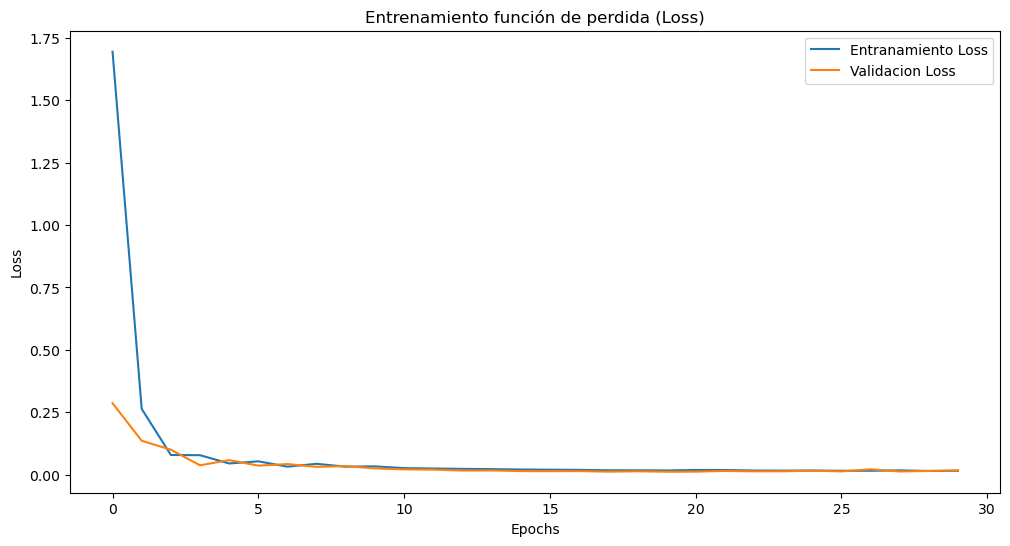

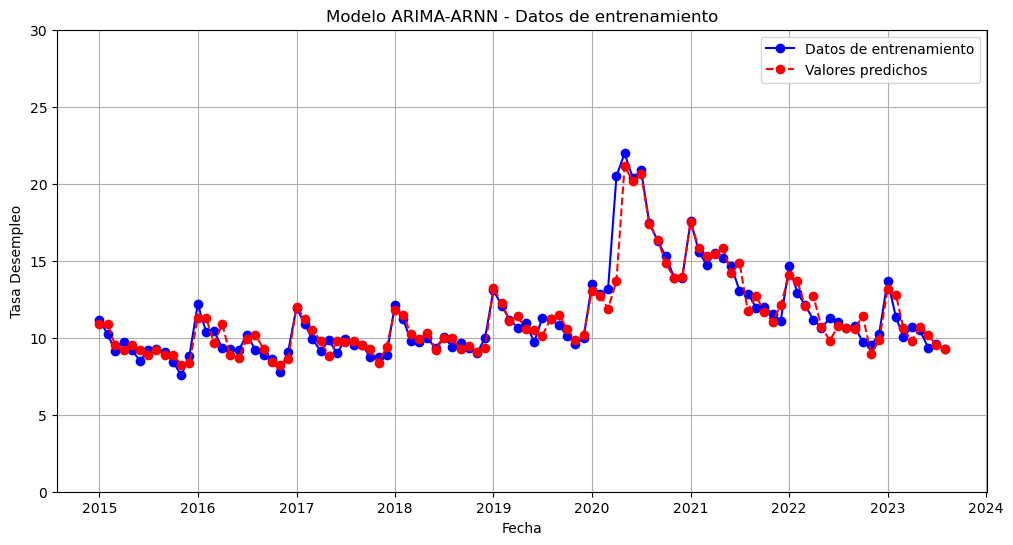

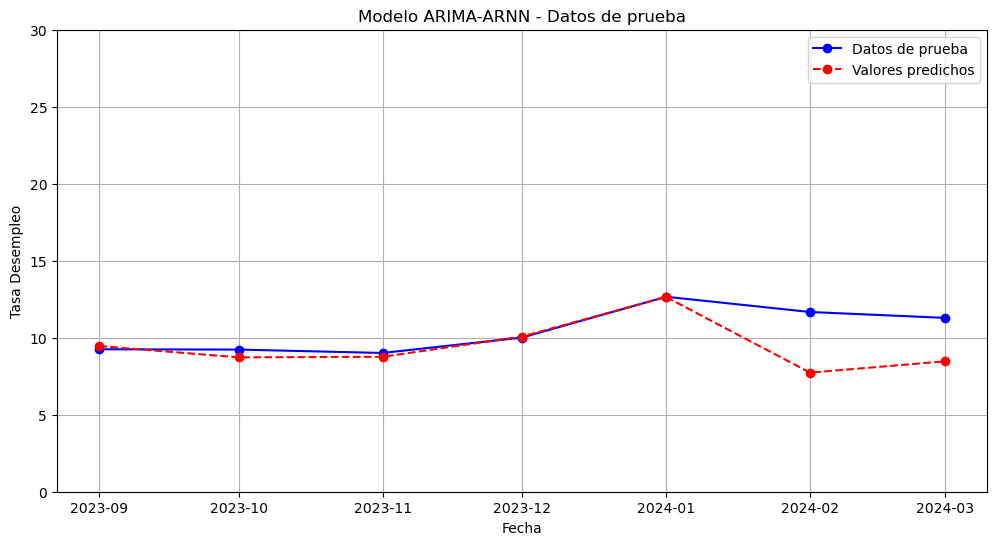

In [176]:
#  Gráfico entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Entranamiento Loss')
plt.plot(history.history['val_loss'], label='Validacion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Entrenamiento función de perdida (Loss)')
plt.show()

# Predicción entrenamiento
plt.figure(figsize=(12,6))
plt.plot(train.index[look_back:], train[look_back:], label='Datos de entrenamiento',marker='o', color='blue', linestyle='-')
plt.plot(train.index[look_back:], combined_train_pred, label='Valores predichos',  marker='o', color='red', linestyle='--')
plt.ylim(0, 30)
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.title('Modelo ARIMA-ARNN - Datos de entrenamiento')
plt.grid(True)
plt.show()

# Predicción datos de prueba
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Datos de prueba',marker='o', color='blue', linestyle='-')
plt.plot(test.index, combined_test_pred, label='Valores predichos', marker='o', color='red', linestyle='--')
plt.ylim(0, 30)
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.title('Modelo ARIMA-ARNN - Datos de prueba')
plt.grid(True)
plt.show()

In [171]:

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Identificar la tasa de aprendizaje seleccionada
best_learning_rate = best_hps.get('learning_rate')
print(f"La mejor tasa de aprendizaje seleccionada es: {best_learning_rate}")


La mejor tasa de aprendizaje seleccionada es: 0.01
